***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.3)** 64-D>32-D>16-D (Coarse>Medium>FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- With $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\Downloads\temp\HD-CapsNet\Training_and_Analysis\5_CU_BIRD
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 16,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('5_CU_Bird/HD_CapsNet/HD_CapsNet')

# Import Dataset : CU BIRD

In [6]:
training_dataset,  test_dataset, val_dataset, tree, info = datasets.CU_Birds_200_2011(image_size=(64, 64), 
                                                                                  batch_size=train_params['batch_size'],
                                                                                  data_aug = 'mixup', # 'mixup'
                                                                                  data_normalizing = None) #'normalize'

In [7]:
for x,y in training_dataset.take(1):
    image_shape = x.shape[1:]
    coarse_label_shape = y[0].shape[1:]
    medium_label_shape = y[1].shape[1:]
    fine_label_shape = y[2].shape[1:]

## Learning Rate Decay Scheduler

In [8]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [9]:
## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": info['Num_Coarse'],
                                "medium": info['Num_Medium'],
                                "fine": info['Num_Fine']})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'medium_lw' : K.variable(value = initial_lw['medium'], dtype="float32", name="medium_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'decoder_lw' : 0.0 ## There is no decoder in this model
             }

In [10]:
Matrix_coarse_to_medium_OneHot = tf.constant(info['Matrix_coarse_to_medium'], dtype=tf.float32)
Matrix_medium_to_fine_OneHot = tf.constant(info['Matrix_medium_to_fine'], dtype=tf.float32)

In [11]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss


def consistency_check(y_pred_ancestor,y_pred_current,lookup_matrix,num_class_current):
    pred_max_ancestor = tf.argmax(y_pred_ancestor,axis=1)
    pred_max_current = tf.argmax(y_pred_current,axis=1)
    
    consistant_check = tf.gather(lookup_matrix, indices=pred_max_ancestor)*tf.one_hot(pred_max_current,num_class_current)
    
    return tf.reduce_sum(consistant_check,1)

def get_consistency(y_true_ancestor, y_pred, lookup_matrix):
    '''
    Get consistency based on 2 levels
    Provide ture levels for the level above, predictions for the current level and a look up metrix
    '''
    y_prob = tf.math.divide(y_pred,tf.reshape(tf.reduce_sum(y_pred,-1),(-1,1),name='reshape'),name='Probability')
    
    index_for_predictions = tf.cast(tf.math.argmax(y_true_ancestor,axis=1),dtype= 'int32')
    consistent_fine = tf.gather(lookup_matrix, indices=index_for_predictions) * y_prob
    Consistency_sum_array = tf.reduce_sum(consistent_fine, axis =1)
    
    return tf.abs(1-Consistency_sum_array)

def CustomLoss(y_true_c, y_true_m, y_true_f, y_pred_c, y_pred_m, y_pred_f, LW_C, LW_M, LW_F,
               number_of_classes_m, number_of_classes_f, C_Weight=0.2):
    
    con_m = consistency_check(y_pred_c,y_pred_m,Matrix_coarse_to_medium_OneHot,num_class_current=number_of_classes_m)
    con_m_not = tf.abs(con_m-1)
    
    con_f = consistency_check(y_pred_m,y_pred_f,Matrix_medium_to_fine_OneHot,num_class_current=number_of_classes_f)
    con_f_not = tf.abs(con_f-1)
    
    con_sum_m = get_consistency(y_true_c,y_pred_m,Matrix_coarse_to_medium_OneHot)
    con_sum_f = get_consistency(y_true_m,y_pred_f,Matrix_medium_to_fine_OneHot)
    
    medium_lvl_cosistency = con_sum_m * con_m_not
    fine_lvl_cosistency = con_sum_f * con_f_not    
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_m = LW_M*((1-C_Weight)*(margin_loss(y_true_m, y_pred_m))+C_Weight*(medium_lvl_cosistency))
    ML_f = LW_F*((1-C_Weight)*(margin_loss(y_true_f, y_pred_f))+C_Weight*(fine_lvl_cosistency))
    
    batch_loss = ML_c + ML_m+ ML_f

    return tf.reduce_mean(batch_loss)

## Architecture

In [12]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_3(input_shape     = image_shape, 
                                      input_shape_yc  = coarse_label_shape,
                                      input_shape_ym  = medium_label_shape,
                                      input_shape_yf  = fine_label_shape, 
                                      no_coarse_class = info['Num_Coarse'], 
                                      no_medium_class = info['Num_Medium'], 
                                      no_fine_class   = info['Num_Fine'],
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 16, 
                                      SCap_m_dims     = 32, 
                                      SCap_c_dims     = 64)
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1], 
                              y_true_m            = model.inputs[2], 
                              y_true_f            = model.inputs[3], 
                              y_pred_c            = model.output[0], 
                              y_pred_m            = model.output[1], 
                              y_pred_f            = model.output[2], 
                              LW_C                = lossweight['coarse_lw'], 
                              LW_M                = lossweight['medium_lw'], 
                              LW_F                = lossweight['fine_lw'],
                              number_of_classes_m = info['Num_Medium'], 
                              number_of_classes_f = info['Num_Fine'], 
                              C_Weight            =0.2)
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_medium': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [13]:
strategy = models.multi_gpu_select('windows')

print("Number of devices: {}".format(strategy.num_replicas_in_sync))

with strategy.scope():
    # Everything that creates variables should be under the strategy scope.
    # In general this is only model construction & `compile()`.
    model = get_compiled_model()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localh

In [14]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 64, 64, 64)   1792        ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 64, 64, 64)   36928       ['batch_normalization[0]

                                                                                                  
 prediction_medium (LengthLayer  (None, 123)         0           ['s_caps_medium[0][0]']          
 )                                                                                                
                                                                                                  
 prediction_fine (LengthLayer)  (None, 200)          0           ['s_caps_fine[0][0]']            
                                                                                                  
 tf.math.argmax_4 (TFOpLambda)  (None,)              0           ['input_yc[0][0]']               
                                                                                                  
 tf.math.reduce_sum_2 (TFOpLamb  (None,)             0           ['prediction_medium[0][0]']      
 da)                                                                                              
          

 )                                                                                                
                                                                                                  
 tf.math.square_2 (TFOpLambda)  (None, 123)          0           ['tf.math.maximum_2[0][0]']      
                                                                                                  
 tf.math.multiply_11 (TFOpLambd  (None, 123)         0           ['tf.math.subtract_9[0][0]']     
 a)                                                                                               
                                                                                                  
 tf.math.square_3 (TFOpLambda)  (None, 123)          0           ['tf.math.maximum_3[0][0]']      
                                                                                                  
 tf.math.reduce_sum_3 (TFOpLamb  (None,)             0           ['tf.math.multiply_2[0][0]']     
 da)      

 )                                                                                                
                                                                                                  
 tf.math.multiply_6 (TFOpLambda  (None, 39)          0           ['input_yc[0][0]',               
 )                                                                'tf.math.square[0][0]']         
                                                                                                  
 tf.math.multiply_8 (TFOpLambda  (None, 39)          0           ['tf.math.multiply_7[0][0]',     
 )                                                                'tf.math.square_1[0][0]']       
                                                                                                  
 tf.math.reduce_sum_7 (TFOpLamb  (None,)             0           ['tf.math.add_1[0][0]']          
 da)                                                                                              
          

## Data Augmentation

## Training Pipeline Alignment

In [15]:
#### Matching the pipeling with model inputs
def pipeline_multi_input_output(image, label):
    label_0 = label[0]
    label_1 = label[1]
    label_2 = label[2]
    return (image, label_0, label_1, label_2), (label_0, label_1, label_2)

training_dataset_match = training_dataset.map(pipeline_multi_input_output) ## Mixup dataset
val_dataset_match = val_dataset.map(pipeline_multi_input_output) ## Val Dataset

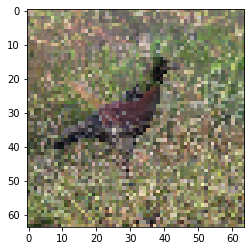

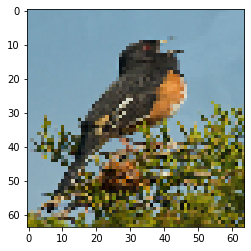

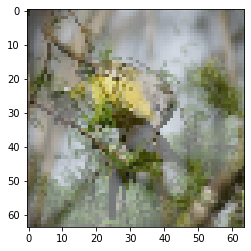

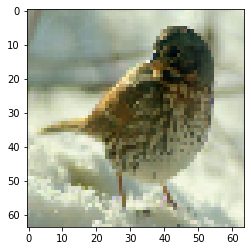

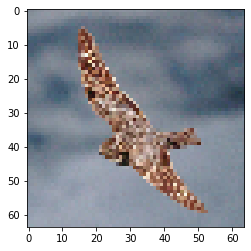

In [16]:
for x,y in training_dataset_match.take(5):
    plt.imshow(x[0][0])
    plt.show()
    

## Callback

In [17]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [18]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_dataset_match,
                        epochs = train_params["n_epochs"],
                        validation_data = val_dataset_match,
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1)
    
    model.save_weights(model_save_dir)

In [19]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Medium": history}, metric = "prediction_medium_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


In [20]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

Trained model weights loaded


## Model Analysis

In [21]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_medium' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_medium' : lossweight['medium_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']},

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_medium': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

In [22]:
results = final_model.evaluate(test_dataset)
for n in range(len(results)):
    print(str(n+1)+'.',final_model.metrics_names[n], '==>', results[n])
model_predictions = final_model.predict(test_dataset)

182/182 [==============================] - 22s 89ms/step - loss: 0.5456 - prediction_coarse_loss: 0.4428 - prediction_medium_loss: 0.6013 - prediction_fine_loss: 0.6685 - prediction_coarse_accuracy: 0.4042 - prediction_medium_accuracy: 0.2161 - prediction_fine_accuracy: 0.1339
1. loss ==> 0.5456342101097107
2. prediction_coarse_loss ==> 0.44276368618011475
3. prediction_medium_loss ==> 0.6013497114181519
4. prediction_fine_loss ==> 0.6685441136360168
5. prediction_coarse_accuracy ==> 0.40421125292778015
6. prediction_medium_accuracy ==> 0.21608561277389526
7. prediction_fine_accuracy ==> 0.13393165171146393


In [23]:
def predict_from_pipeline(model, dataset):
    y_pred = []
    y_true = []
    for x, y in dataset:
        batch_pred = model.predict(x)
        for i in range(len(batch_pred)):
            if i >= len(y_pred):
                y_pred.append(None)
                y_true.append(None)
            if y_pred[i] is None:
                y_pred[i] = batch_pred[i]
                y_true[i] = list(y[i].numpy())
            else:
                y_pred[i] = np.concatenate([y_pred[i], batch_pred[i]])
                y_true[i] = y_true[i] + list(y[i].numpy())
    return y_true, y_pred

In [24]:
predictions = []
predictions.append(predict_from_pipeline(final_model, test_dataset))

In [25]:
dataset= {'y_test_coarse':predictions[0][0][0], 
          'y_test_medium':predictions[0][0][1], 
          'y_test_fine':predictions[0][0][2]}

In [26]:
true_label = [dataset['y_test_coarse'],dataset['y_test_medium'],dataset['y_test_fine']]
pred_label = [predictions[0][1][0],predictions[0][1][1],predictions[0][1][2]]

  • Confusion_Matrix Level = 0 


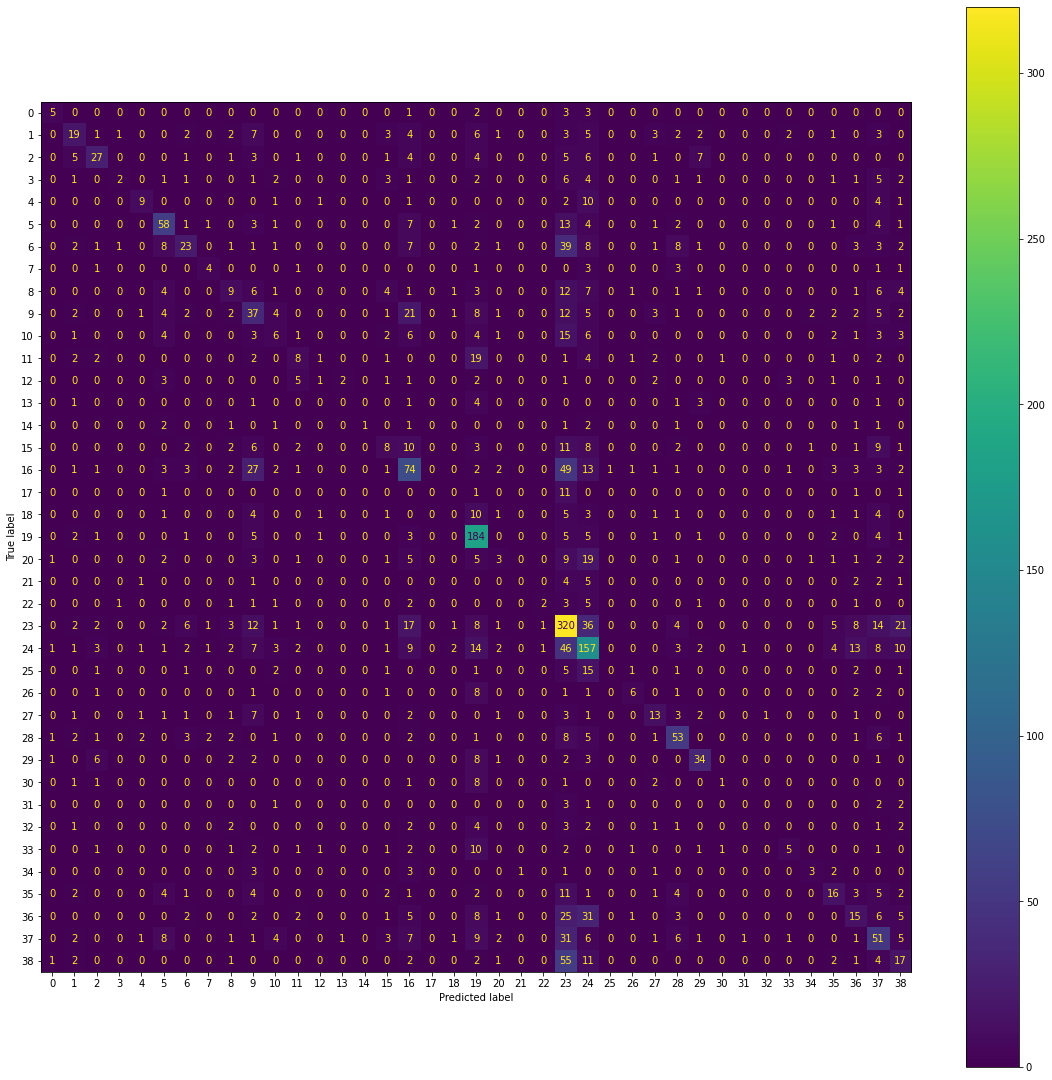


  • Classification Report for Level = 0 

              precision    recall  f1-score   support

           0    0.50000   0.35714   0.41667        14
           1    0.38000   0.28358   0.32479        67
           2    0.54000   0.40909   0.46552        66
           3    0.40000   0.05714   0.10000        35
           4    0.56250   0.31034   0.40000        29
           5    0.54206   0.58000   0.56039       100
           6    0.44231   0.20354   0.27879       113
           7    0.44444   0.26667   0.33333        15
           8    0.25000   0.14516   0.18367        62
           9    0.24342   0.31356   0.27407       118
          10    0.18750   0.10345   0.13333        58
          11    0.29630   0.17021   0.21622        47
          12    0.16667   0.04348   0.06897        23
          13    0.00000   0.00000   0.00000        12
          14    1.00000   0.08333   0.15385        12
          15    0.21053   0.12121   0.15385        66
          16    0.36453   0.37563   0.

C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\knoor\.conda\envs\py38tf\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


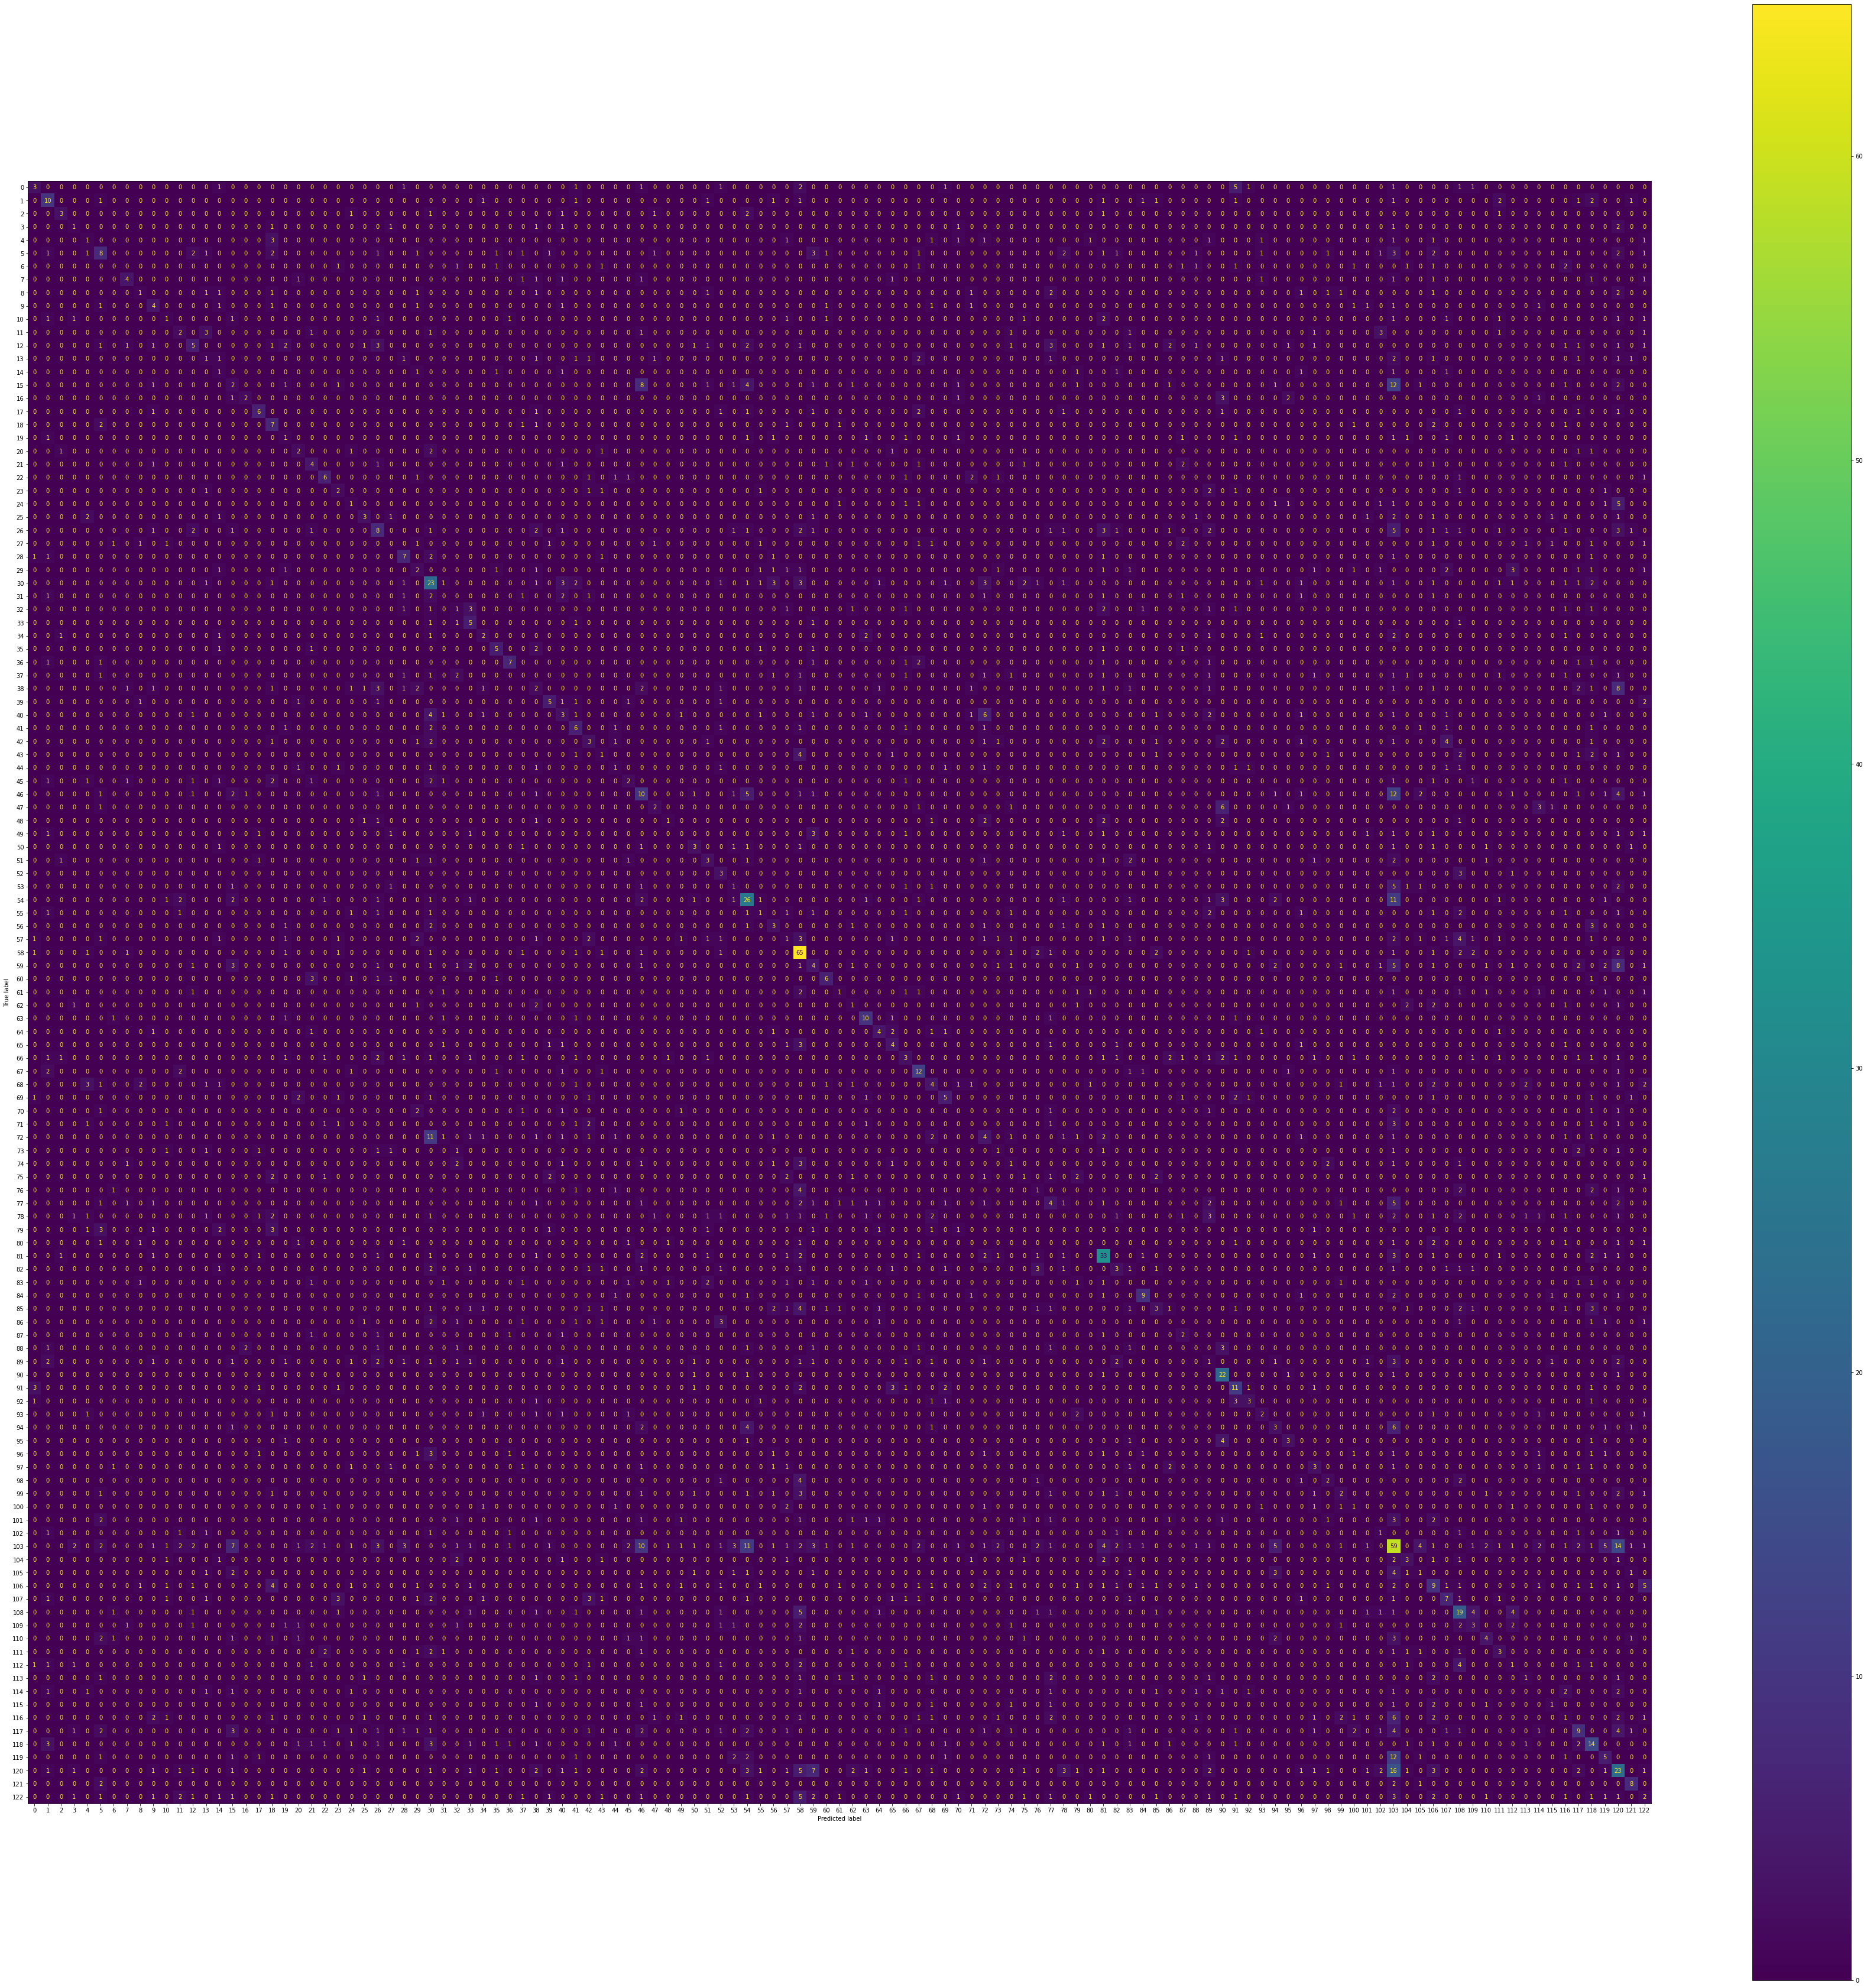


  • Classification Report for Level = 1 

              precision    recall  f1-score   support

           0    0.25000   0.15000   0.18750        20
           1    0.30303   0.37037   0.33333        27
           2    0.37500   0.27273   0.31579        11
           3    0.10000   0.11111   0.10526         9
           4    0.07143   0.07143   0.07143        14
           5    0.20513   0.19048   0.19753        42
           6    0.00000   0.00000   0.00000        13
           7    0.36364   0.26667   0.30769        15
           8    0.12500   0.06250   0.08333        16
           9    0.20000   0.25000   0.22222        16
          10    0.10000   0.06250   0.07692        16
          11    0.15385   0.12500   0.13793        16
          12    0.23810   0.14286   0.17857        35
          13    0.06667   0.05882   0.06250        17
          14    0.05556   0.11111   0.07407         9
          15    0.06250   0.04878   0.05479        41
          16    0.40000   0.20000   0.

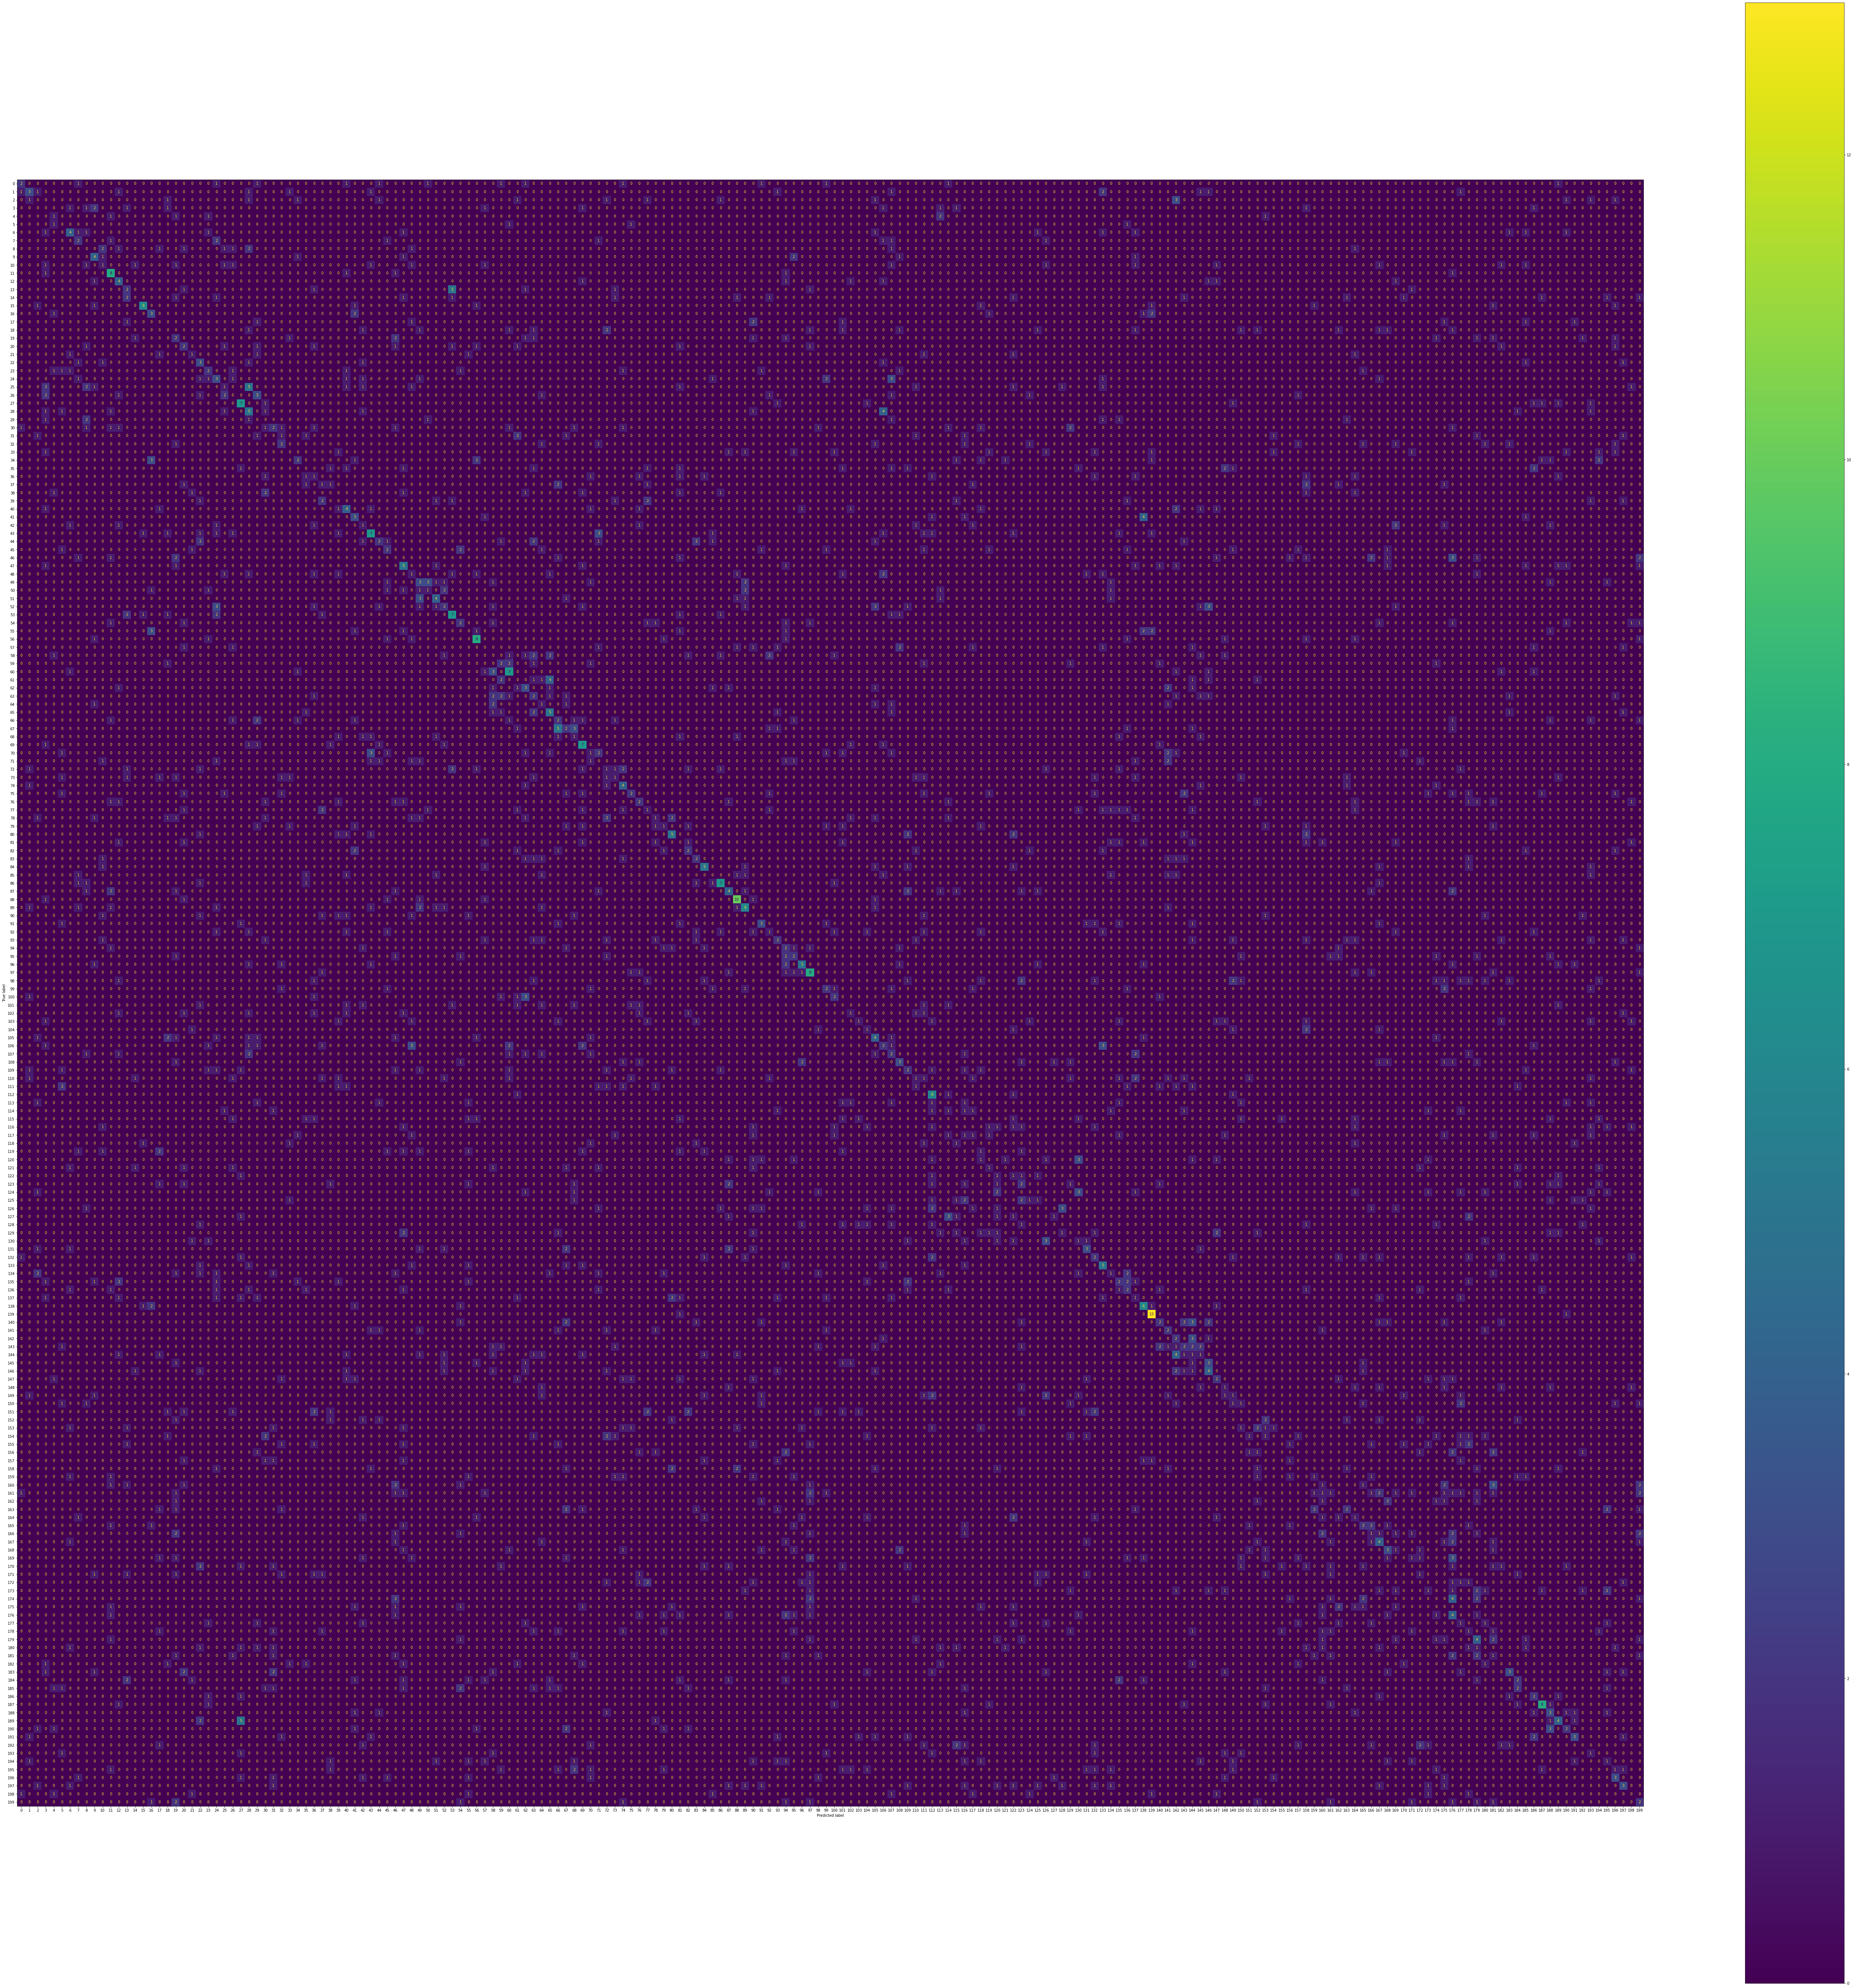


  • Classification Report for Level = 2 

              precision    recall  f1-score   support

           0    0.28571   0.13333   0.18182        15
           1    0.23077   0.18750   0.20690        16
           2    0.00000   0.00000   0.00000        16
           3    0.00000   0.00000   0.00000        13
           4    0.10000   0.14286   0.11765         7
           5    0.00000   0.00000   0.00000         4
           6    0.23529   0.25000   0.24242        16
           7    0.15385   0.20000   0.17391        10
           8    0.00000   0.00000   0.00000        12
           9    0.23529   0.36364   0.28571        11
          10    0.08333   0.05882   0.06897        17
          11    0.28571   0.61538   0.39024        13
          12    0.20000   0.33333   0.25000        12
          13    0.12500   0.15385   0.13793        13
          14    0.00000   0.00000   0.00000        16
          15    0.60000   0.40000   0.48000        15
          16    0.21429   0.30000   0.

In [27]:
metrics.lvl_wise_metric(true_label,pred_label,directory)

In [37]:
h_measurements,consistency,exact_match, get_performance_report = metrics.hmeasurements(true_label, pred_label, tree)

get_performance_report = {**{'Dataset': 'CUB',
                             'Model': 'HD-CapsNet'},
                             **get_performance_report
                             } # merging two dictionaries (adding Dataset and Model name)
performance_metrics = pd.DataFrame(pd.DataFrame(get_performance_report.values(), get_performance_report.keys(), columns = ['Value']))
performance_metrics.to_csv(os.path.join(directory,'performance_metrics.csv'))
display(performance_metrics)

,Value
Dataset,CUB
Model,HD-CapsNet
Accuracy L_0,0.404211
Accuracy L_1,0.216086
Accuracy L_2,0.133932
HarmonicM_Accuracy_k1,0.205927
HarmonicM_Accuracy_k2,0.285757
HarmonicM_Accuracy_k5,0.401825
ArithmeticM_Accuracy_k1,0.25141
ArithmeticM_Accuracy_k2,0.33736
